In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.utils import class_weight
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


from os import listdir
from os.path import isfile, join

import pandas as pd

In [2]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [3]:
train_loc = './COVIDspec/train/'
test_loc = './COVIDspec/val/'

In [31]:
trdata = ImageDataGenerator(preprocessing_function=preprocess_input)
train_data = trdata.flow_from_directory(directory=train_loc, target_size=(515,389))
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = tsdata.flow_from_directory(directory=test_loc, target_size=(515,389))

Found 4939 images belonging to 2 classes.
Found 1236 images belonging to 2 classes.


In [32]:
traindata = crop_generator(train_data, 224)
testdata = crop_generator(test_data, 224)

In [25]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [26]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-20:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)  

Layer 'block1_pool' is trainable
Layer 'block2_conv1' is trainable
Layer 'block2_conv2' is trainable
Layer 'block2_pool' is trainable
Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [27]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy', 'mae'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [28]:
checkpoint = ModelCheckpoint("vgg16_covid_rand.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [29]:
counter = Counter(train_data.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 10.302059496567505, 1: 1.0}

In [33]:
hist = model.fit(traindata, steps_per_epoch=train_data.samples//train_data.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=test_data.samples//test_data.batch_size, 
                 epochs=110,callbacks=[checkpoint,early])

Epoch 1/110
154/154 [==============================] - ETA: 0s - loss: 1.3053 - accuracy: 0.5438 - mae: 0.4844
Epoch 00001: val_accuracy improved from -inf to 0.53701, saving model to vgg16_covid_rand.h5
154/154 [==============================] - 85s 549ms/step - loss: 1.3053 - accuracy: 0.5438 - mae: 0.4844 - val_loss: 0.6871 - val_accuracy: 0.5370 - val_mae: 0.4889
Epoch 2/110
154/154 [==============================] - ETA: 0s - loss: 1.2846 - accuracy: 0.5321 - mae: 0.4920
Epoch 00002: val_accuracy did not improve from 0.53701
154/154 [==============================] - 49s 319ms/step - loss: 1.2846 - accuracy: 0.5321 - mae: 0.4920 - val_loss: 0.8522 - val_accuracy: 0.2122 - val_mae: 0.5633
Epoch 3/110
154/154 [==============================] - ETA: 0s - loss: 1.2607 - accuracy: 0.5447 - mae: 0.4895
Epoch 00003: val_accuracy improved from 0.53701 to 0.68997, saving model to vgg16_covid_rand.h5
154/154 [==============================] - 53s 343ms/step - loss: 1.2607 - accuracy: 0.5447

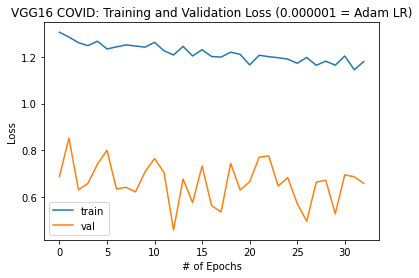

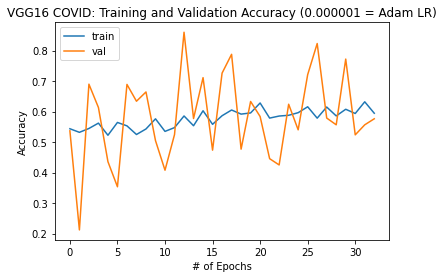

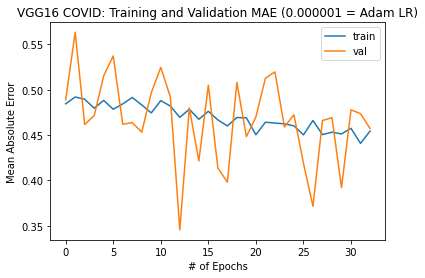

In [34]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16 COVID: Training and Validation Loss (0.000001 = Adam LR)')
plt.xlabel('# of Epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig('covidVGG16loss.png')
plt.show()


plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16 COVID: Training and Validation Accuracy (0.000001 = Adam LR)')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.savefig('covidVGG16accuracy.png')
plt.show()


plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('VGG16 COVID: Training and Validation MAE (0.000001 = Adam LR)')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend();
plt.savefig('covidVGG16mae.png')
plt.show()

In [ ]:
Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [19]:
cm = confusion_matrix(testdata.classes,y_pred)

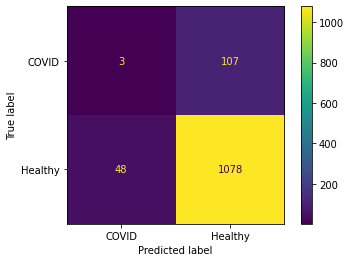

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['COVID','Healthy'])
disp.plot()